In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# convert the datatype
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## load data, merge data and clean data

In [30]:
data = pd.read_csv('./data/6 train.csv')
weather_2015 = pd.read_excel('./data/shanghai weather_2015.xlsx', sheet_name=0, index_col=None)
weather_2016 = pd.read_excel('./data/shanghai weather_2016.xlsx', sheet_name=0, index_col=None)
weather_2017 = pd.read_excel('./data/shanghai weather_2017.xlsx', sheet_name=0, index_col=None)
# 读入train_building_info
building_info_data = pd.read_excel('./data/5 train_building_info.xlsx')

In [31]:
data = reduce_mem_usage(data)
weather_2015 = reduce_mem_usage(weather_2015)
weather_2016 = reduce_mem_usage(weather_2016)
weather_2017 = reduce_mem_usage(weather_2017)

Mem. usage decreased to 20.98 Mb (34.4% reduction)
Mem. usage decreased to  0.15 Mb (62.5% reduction)
Mem. usage decreased to  0.15 Mb (62.5% reduction)
Mem. usage decreased to  0.15 Mb (62.5% reduction)


In [32]:
# 修改列名
weather_2015 = weather_2015.rename(columns={'time':'Time', '温度（℃）':'temp', '露点温度（℃）':'dew point', '相对湿度（%）':'relative humidity', '气压（pa）':'air pressure', '风速（m/s）':'wind speed'}, copy=False)
weather_2016 = weather_2016.rename(columns={'time':'Time', '温度（℃）':'temp', '露点温度（℃）':'dew point', '相对湿度（%）':'relative humidity', '气压（pa）':'air pressure', '风速（m/s）':'wind speed'}, copy=False)
weather_2017 = weather_2017.rename(columns={'time':'Time', '温度（℃）':'temp', '露点温度（℃）':'dew point', '相对湿度（%）':'relative humidity', '气压（pa）':'air pressure', '风速（m/s）':'wind speed'}, copy=False)
weather  = pd.concat([weather_2015, weather_2016, weather_2017], ignore_index=True)
data['Time'] = pd.to_datetime(data['Time'])
del weather_2015, weather_2016, weather_2017
gc.collect()

26374

In [35]:
merge_data = pd.merge(data, weather, how='inner', on=['Time'])
del data, weather
gc.collect()

0

In [43]:
# encoding the HVAC types
building_info_data['Encoded-HVACType'] = building_info_data['HVACType'].astype('category').cat.codes.values
building_info_data['Encoded-Type'] = building_info_data['Type'].astype('category').cat.codes.values
merge_data = pd.merge(merge_data, building_info_data, how='left', on='BuildingID')
merge_data.head()

Time BuildingID Type      Record  temp  dew point  relative humidity  \
0 2015-01-01          0    Q  222.000000   1.5      -12.0               36.5   
1 2015-01-01          0    W  203.149994   1.5      -12.0               36.5   
2 2015-01-01          1    Q  310.500000   1.5      -12.0               36.5   
3 2015-01-01          1    W   35.509998   1.5      -12.0               36.5   
4 2015-01-01          2    Q   91.279999   1.5      -12.0               36.5   

   air pressure  wind speed  Stair1  Stair2      Area   HVACType  \
0        1033.0   16.203125       6       1  77563.54   集中式全空气系统   
1        1033.0   16.203125       6       1  77563.54   集中式全空气系统   
2        1033.0   16.203125      26       1  34275.60   集中式全空气系统   
3        1033.0   16.203125      26       1  34275.60   集中式全空气系统   
4        1033.0   16.203125      30       2  38232.30  风机盘管＋新风系统   

   Encoded-HVACType  
0                 2  
1                 2  
2                 2  
3                 2  
4                 3

In [51]:
# process null values 
weather_feature = ['temp','dew point','relative humidity',	'air pressure',	'wind speed']
for col in weather_feature:
    null_no = len(merge_data[merge_data[col].isnull()])
    print(f'column {col} has {null_no} of null values')
    if null_no > 0:
        merge_data[col].fillna(method ='ffill', inplace = True)

column temp has 0 of null values
column dew point has 0 of null values
column relative humidity has 0 of null values
column air pressure has 0 of null values
column wind speed has 0 of null values


In [52]:
# 负值赋值为前一天同时间数值
for i in list(merge_data.index[merge_data['Record']<0]):
    k = merge_data.loc[i-48,'Record']
    merge_data.loc[i,'Record'] = k

In [74]:
data_Q = merge_data[merge_data['Type']=='Q']
data_Q.loc[(data_Q['Record'] > 20000) & (data_Q['BuildingID']==1)]['Record'] = None
data_Q[data_Q['Record'].isnull()]

Empty DataFrame
Columns: [Time, BuildingID, Type, Record, temp, dew point, relative humidity, air pressure, wind speed, Stair1, Stair2, Area, HVACType, Encoded-HVACType]
Index: []

In [156]:
# plot the chart to see raw data
data_Q = merge_data[merge_data['Type']=='Q'].reset_index()
# 插值处理
for i in list(data_Q.index[data_Q['Record'] > 20000]):
    k = (data_Q.loc[i-1,'Record'] + data_Q.loc[i+1, 'Record']) / 2
    data_Q.loc[i,'Record'] = k

# 手动插值！！
data_Q.loc[452294,'Record'] = (data_Q.loc[452292,'Record'] + data_Q.loc[452296,'Record']) / 2
data_Q.loc[452293,'Record'] = (data_Q.loc[452292,'Record'] + data_Q.loc[452294,'Record']) / 2
data_Q.loc[452295,'Record'] = (data_Q.loc[452294,'Record'] + data_Q.loc[452296,'Record']) / 2

# 插值处理
for i in list(data_Q.index[data_Q['Record'] > 5000]):
    k = (data_Q.loc[i-1,'Record'] + data_Q.loc[i+1, 'Record']) / 2
    data_Q.loc[i,'Record'] = k

#
data_W = merge_data[merge_data['Type']=='W'].reset_index()
# 插值处理
for i in list(data_W.index[data_W['Record'] > 25000]):
    k = (data_W.loc[i-1,'Record'] + data_W.loc[i+1, 'Record']) / 2
    data_W.loc[i,'Record'] = k

for i in list(data_W.index[data_W['Record'] > 3000]):
    k = (data_W.loc[i-1,'Record'] + data_W.loc[i+1, 'Record']) / 2
    data_W.loc[i,'Record'] = k

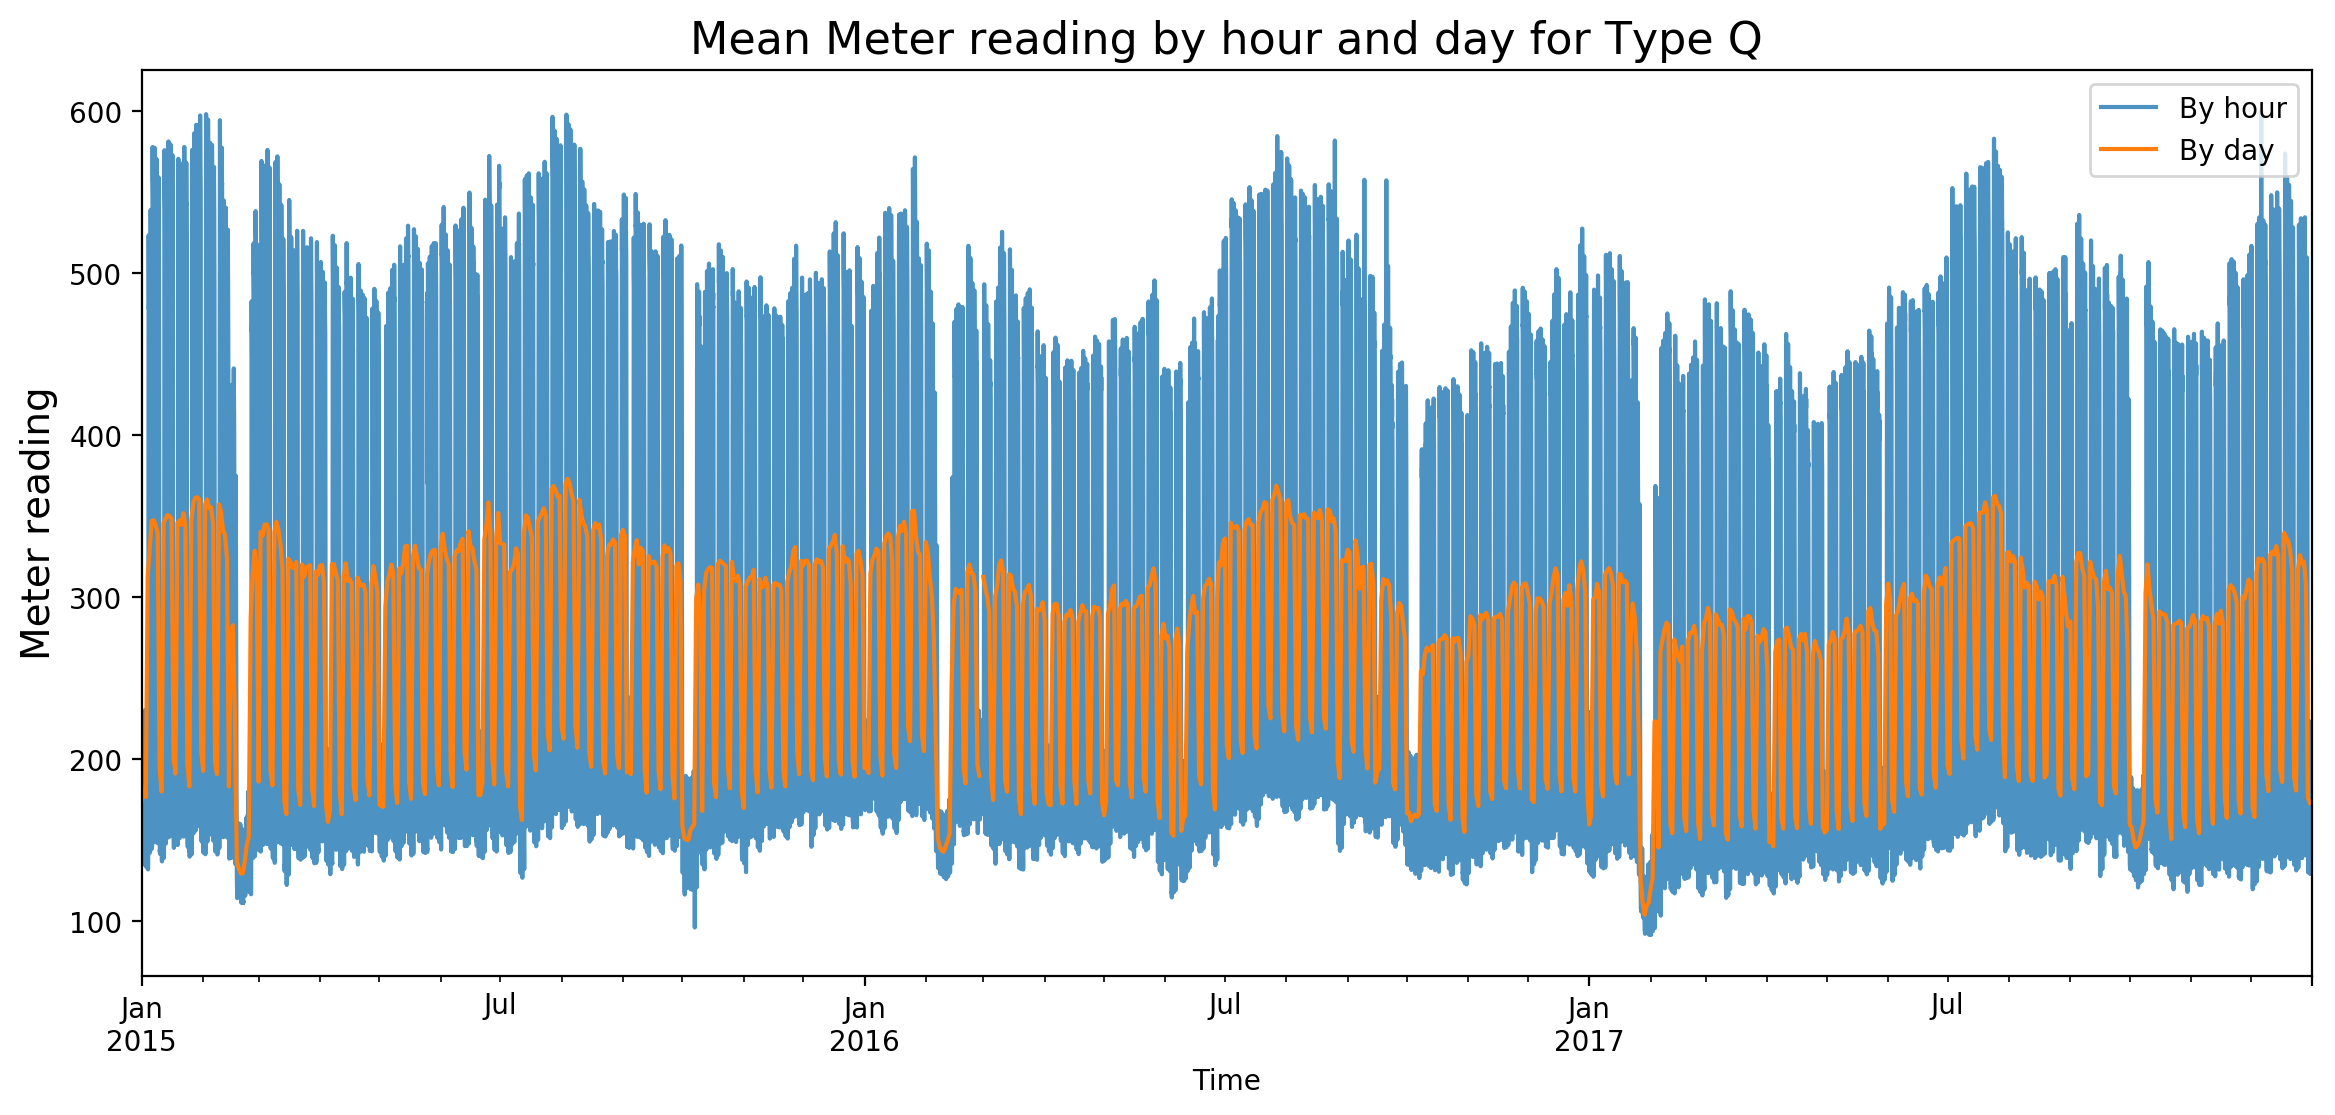

In [110]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6), dpi=100)
data_Q[['Time', 'Record']].set_index('Time').resample('H').mean()['Record'].plot(ax=axes, label='By hour', alpha=0.8).set_ylabel('Meter reading', fontsize=14)
data_Q[['Time', 'Record']].set_index('Time').resample('D').mean()['Record'].plot(ax=axes, label='By day', alpha=1).set_ylabel('Meter reading', fontsize=14)
axes.set_title('Mean Meter reading by hour and day for Type Q', fontsize=16)
axes.legend()

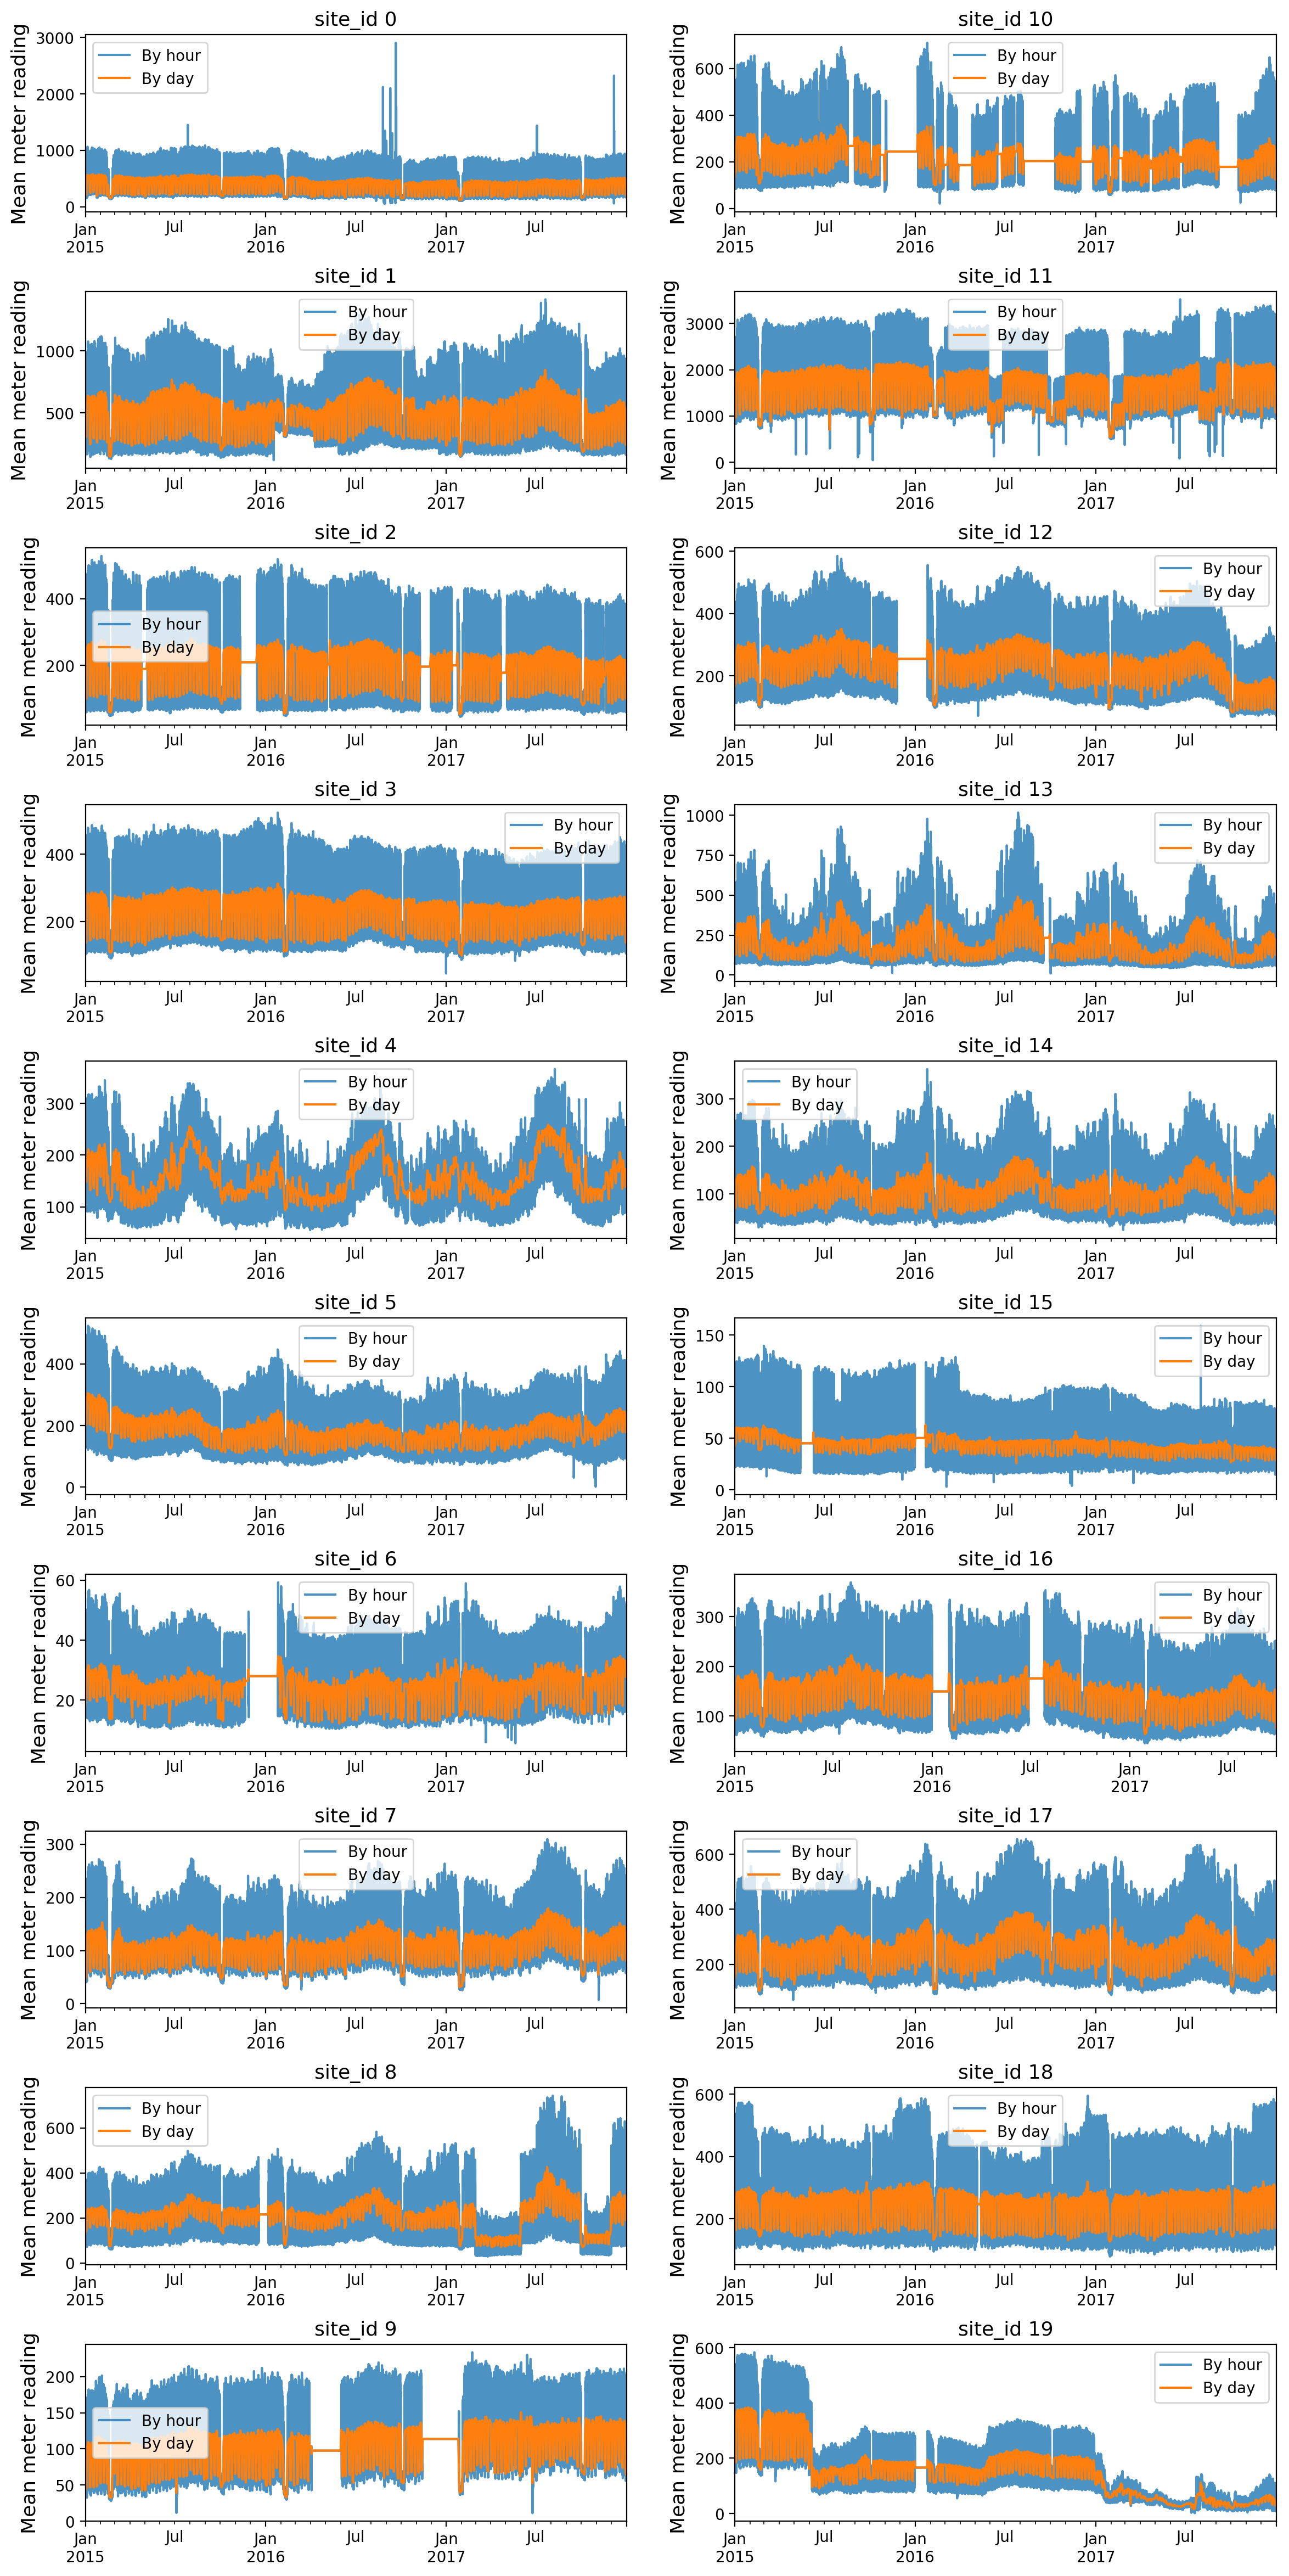

In [109]:
fig, axes = plt.subplots(10,2,figsize=(14, 30), dpi=100)
for i in range(data_Q['BuildingID'].nunique()):
    data_Q[data_Q['BuildingID'] == i][['Time', 'Record']].set_index('Time').resample('H').mean()['Record'].plot(ax=axes[i%10][i//10], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13)
    data_Q[data_Q['BuildingID'] == i][['Time', 'Record']].set_index('Time').resample('D').mean()['Record'].plot(ax=axes[i%10][i//10], alpha=1, label='By day', color='tab:orange').set_xlabel('')
    axes[i%10][i//10].legend()
    axes[i%10][i//10].set_title('site_id {}'.format(i), fontsize=13)
    plt.subplots_adjust(hspace=0.45)

In [157]:
#  having constant values issue building numbers are: 9, 19, 6, 16, 2, 15, 12, 10
#  using by hour value == by day value to identify the position -- take the example of site 9 
#  prob_sites = [9, 19, 6, 16, 2, 15, 12, 10]
df_clean_Q = pd.DataFrame()
for i in range(data_Q['BuildingID'].nunique()):
    data_Q_building  = data_Q[data_Q['BuildingID'] == i]
    # data_Q = data_Q.drop(data_Q[data_Q['BuildingID'] == i].index)
    print(f'the original data length for building {i} is {len(data_Q_building)}')
    by_day = data_Q_building[['Time', 'Record']].set_index('Time').resample('D').mean().rename(columns ={'Record': 'By_day_record'}).resample('H').pad()
    data_Q_building = pd.merge(data_Q_building, by_day, how='inner', on=['Time'])
    data_Q_building['continous_value_flag'] = data_Q_building[['Record', 'By_day_record']].apply(lambda x: 1 if x['Record']==x['By_day_record'] else 0, axis =1)
    N_con = len(data_Q_building[data_Q_building['continous_value_flag'] == 1])
    print(f'the continous constant data length for building {i} is {N_con}')
    df_clean_Q  = pd.concat([df_clean_Q, data_Q_building], ignore_index=True)
del data_Q, by_day, data_Q_building
gc.collect()

the original data length for building 0 is 26280
the continous constant data length for building 0 is 0
the original data length for building 1 is 26280
the continous constant data length for building 1 is 0
the original data length for building 2 is 26280
the continous constant data length for building 2 is 29
the original data length for building 3 is 26280
the continous constant data length for building 3 is 0
the original data length for building 4 is 26280
the continous constant data length for building 4 is 0
the original data length for building 5 is 26280
the continous constant data length for building 5 is 0
the original data length for building 6 is 26280
the continous constant data length for building 6 is 44
the original data length for building 7 is 26280
the continous constant data length for building 7 is 0
the original data length for building 8 is 26280
the continous constant data length for building 8 is 0
the original data length for building 9 is 26280
the continous

397

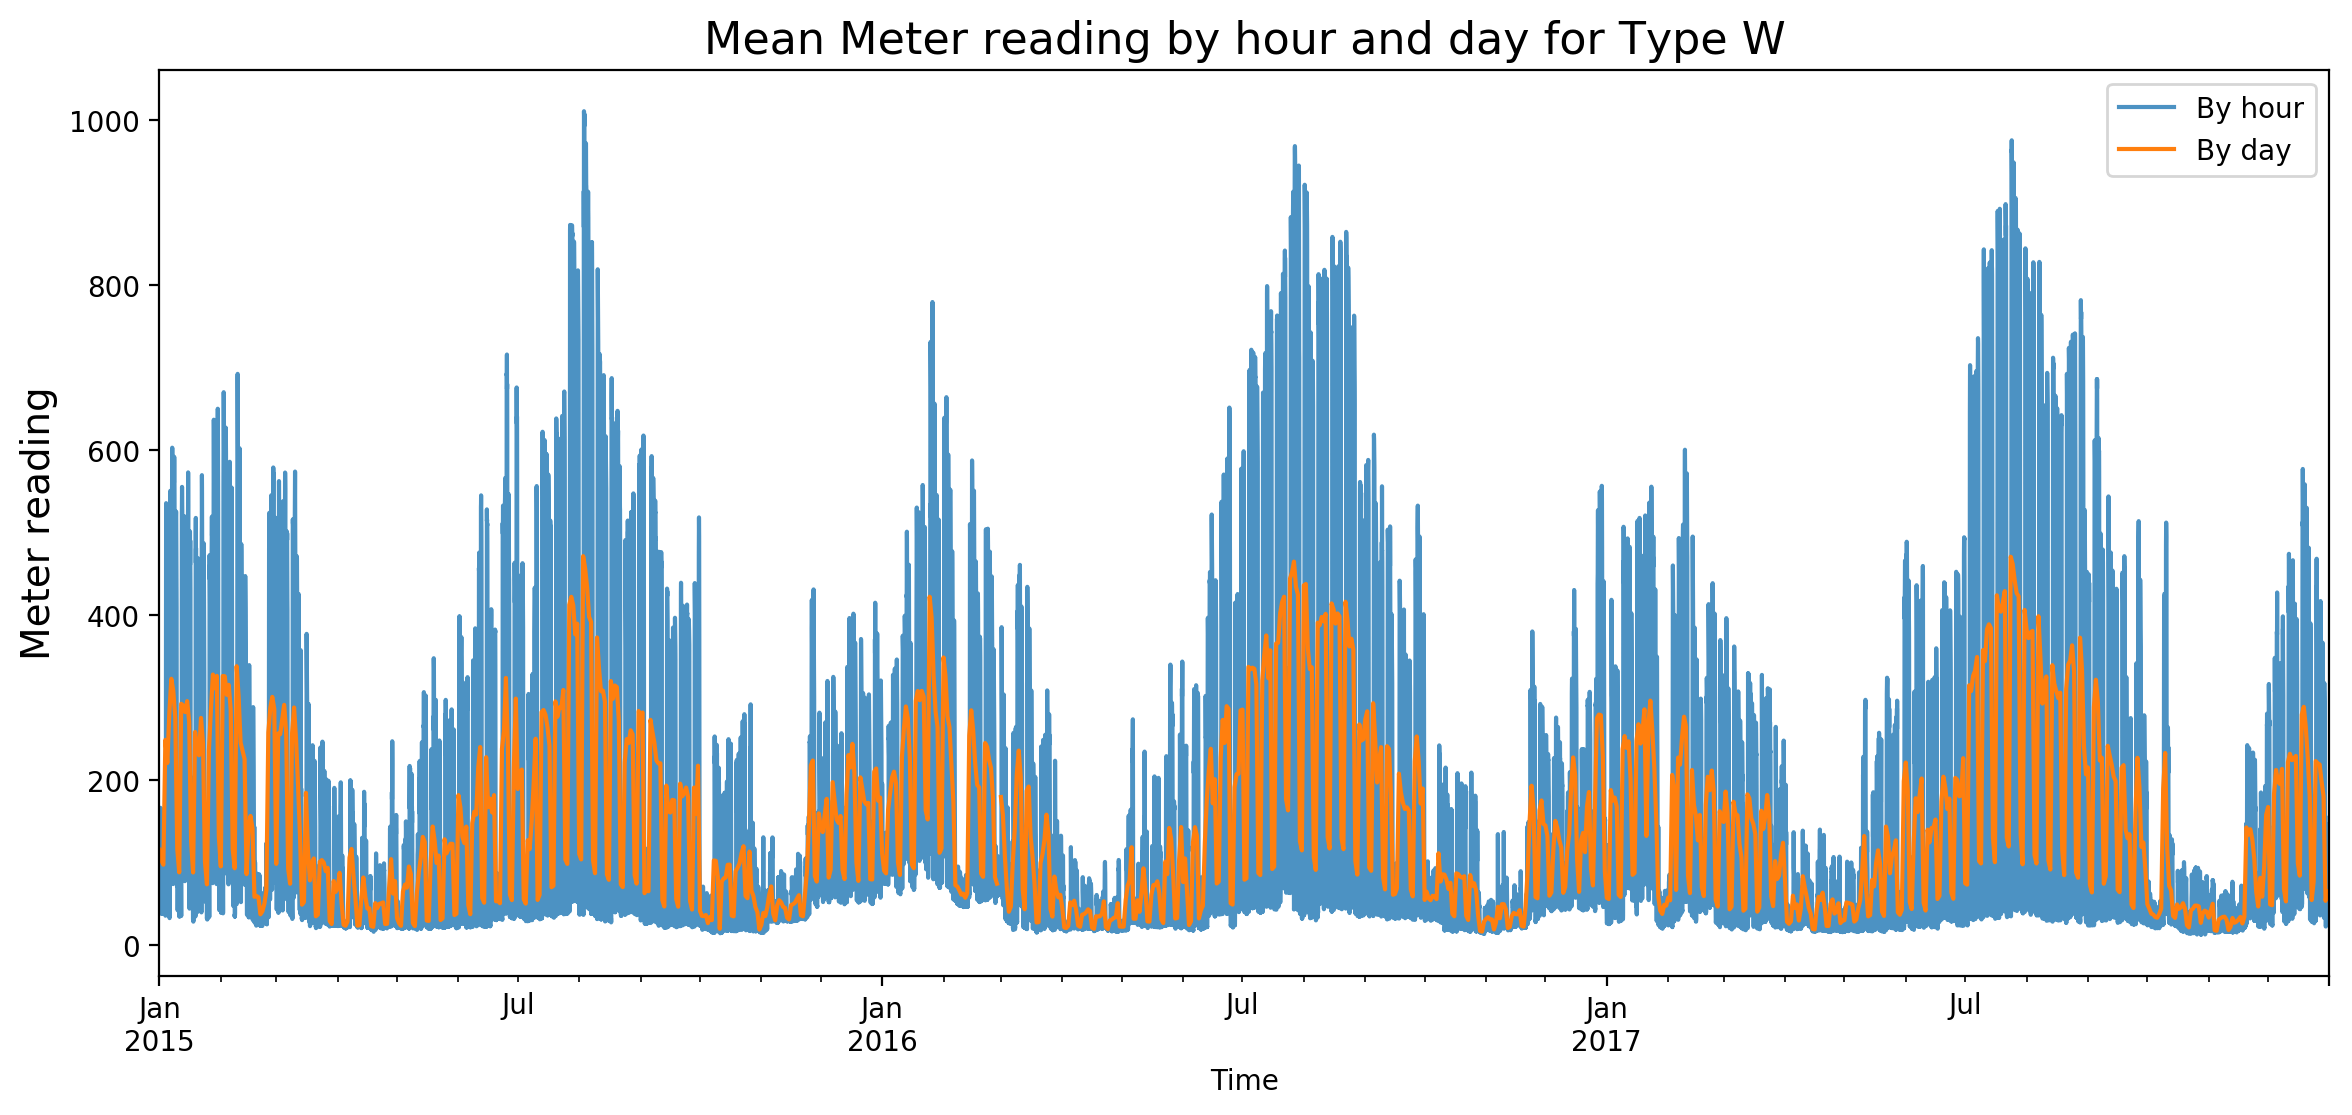

In [158]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6), dpi=100)
data_W[['Time', 'Record']].set_index('Time').resample('H').mean()['Record'].plot(ax=axes, label='By hour', alpha=0.8).set_ylabel('Meter reading', fontsize=14)
data_W[['Time', 'Record']].set_index('Time').resample('D').mean()['Record'].plot(ax=axes, label='By day', alpha=1).set_ylabel('Meter reading', fontsize=14)
axes.set_title('Mean Meter reading by hour and day for Type W', fontsize=16)
axes.legend()

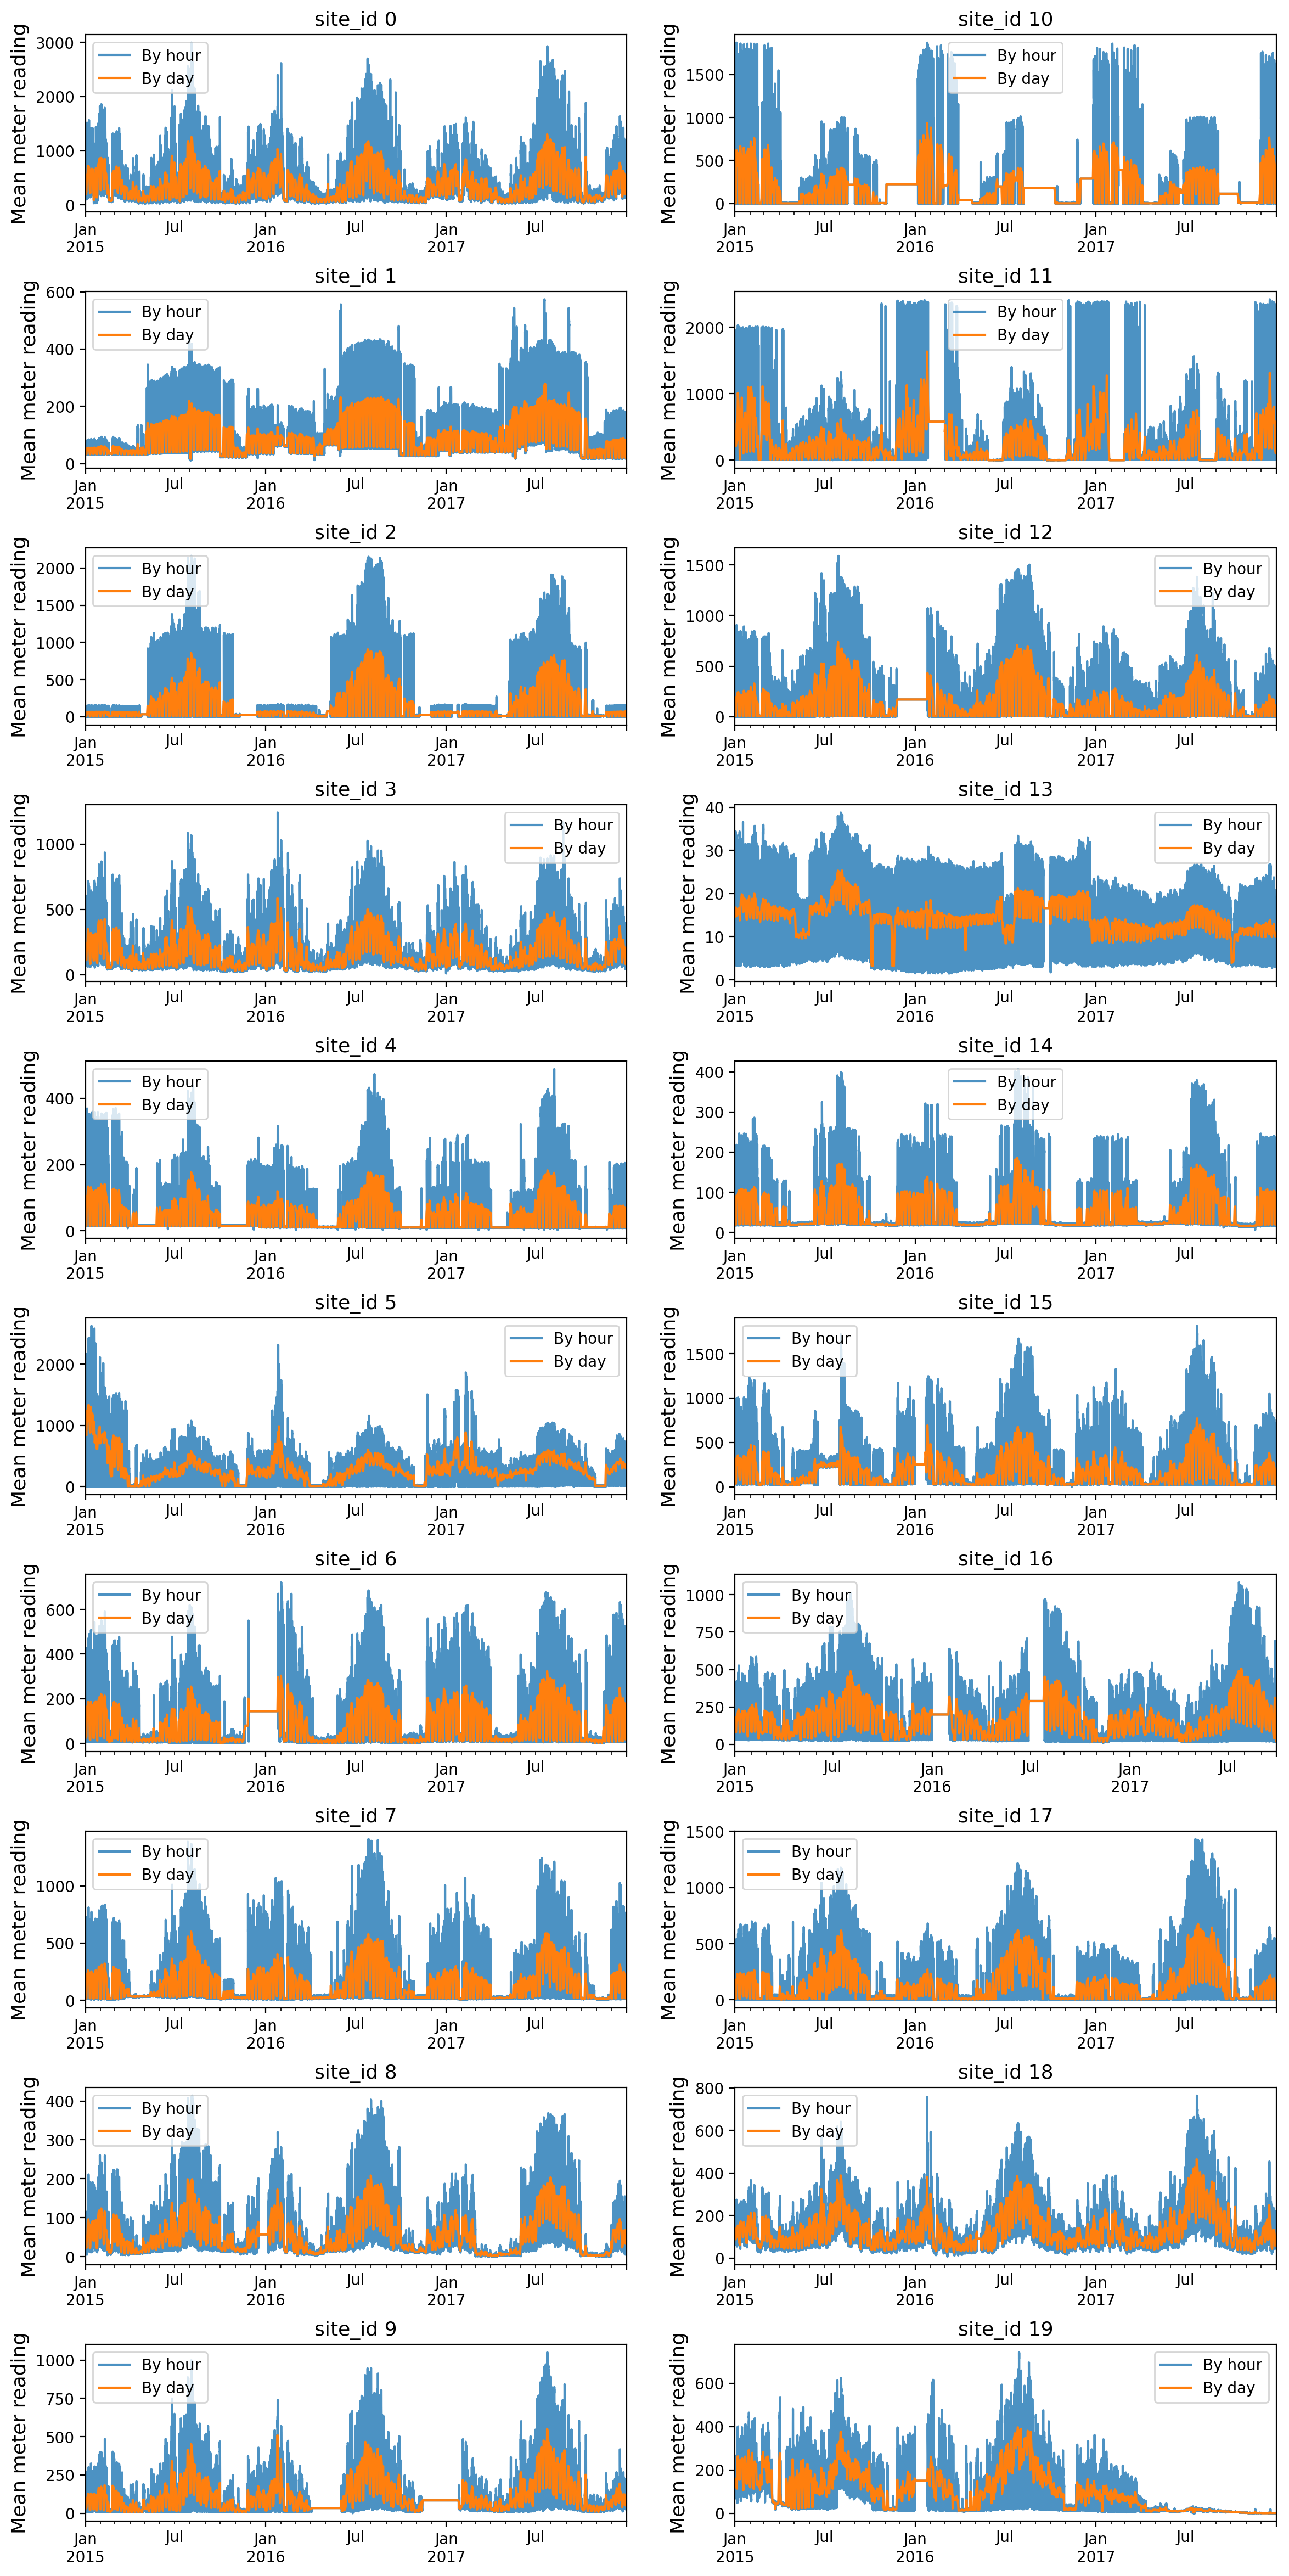

In [159]:
fig, axes = plt.subplots(10,2,figsize=(14, 30), dpi=100)
for i in range(data_W['BuildingID'].nunique()):
    data_W[data_W['BuildingID'] == i][['Time', 'Record']].set_index('Time').resample('H').mean()['Record'].plot(ax=axes[i%10][i//10], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13)
    data_W[data_W['BuildingID'] == i][['Time', 'Record']].set_index('Time').resample('D').mean()['Record'].plot(ax=axes[i%10][i//10], alpha=1, label='By day', color='tab:orange').set_xlabel('')
    axes[i%10][i//10].legend()
    axes[i%10][i//10].set_title('site_id {}'.format(i), fontsize=13)
    plt.subplots_adjust(hspace=0.45)

In [160]:
df_clean_W = pd.DataFrame()
for i in range(data_W['BuildingID'].nunique()):
    data_W_building  = data_W[data_W['BuildingID'] == i]
    # data_Q = data_Q.drop(data_Q[data_Q['BuildingID'] == i].index)
    print(f'the original data length for building {i} is {len(data_W_building)}')
    by_day = data_W_building[['Time', 'Record']].set_index('Time').resample('D').mean().rename(columns ={'Record': 'By_day_record'}).resample('H').pad()
    data_W_building = pd.merge(data_W_building, by_day, how='inner', on=['Time'])
    data_W_building['continous_value_flag'] = data_W_building[['Record', 'By_day_record']].apply(lambda x: 1 if x['Record']==x['By_day_record'] else 0, axis =1)
    N_con = len(data_W_building[data_W_building['continous_value_flag'] == 1])
    print(f'the continous constant data length for building {i} is {N_con}')
    df_clean_W  = pd.concat([df_clean_W, data_W_building], ignore_index=True)
del data_W, by_day, data_W_building
gc.collect()

the original data length for building 0 is 26280
the continous constant data length for building 0 is 0
the original data length for building 1 is 26280
the continous constant data length for building 1 is 1
the original data length for building 2 is 26280
the continous constant data length for building 2 is 9
the original data length for building 3 is 26280
the continous constant data length for building 3 is 0
the original data length for building 4 is 26280
the continous constant data length for building 4 is 6
the original data length for building 5 is 26280
the continous constant data length for building 5 is 0
the original data length for building 6 is 26280
the continous constant data length for building 6 is 7
the original data length for building 7 is 26280
the continous constant data length for building 7 is 1
the original data length for building 8 is 26280
the continous constant data length for building 8 is 7
the original data length for building 9 is 26280
the continous c

133

In [163]:
df_clean = pd.concat([df_clean_W, df_clean_Q], ignore_index=True)
del df_clean_W, df_clean_Q
gc.collect()

0

In [172]:
N_con = len(df_clean[df_clean['continous_value_flag'] == 1])
print(N_con)
df_clean = reduce_mem_usage(df_clean)
df_clean.info()

8376
Mem. usage decreased to 53.86 Mb (0.0% reduction)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045768 entries, 0 to 1045767
Data columns (total 16 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   Time                  1045768 non-null  datetime64[ns]
 1   BuildingID            1045768 non-null  object        
 2   Type                  1045768 non-null  object        
 3   Record                1045768 non-null  float16       
 4   temp                  1045768 non-null  float16       
 5   dew point             1045768 non-null  float16       
 6   relative humidity     1045768 non-null  float16       
 7   air pressure          1045768 non-null  float16       
 8   wind speed            1045768 non-null  float16       
 9   Stair1                1045768 non-null  int8          
 10  Stair2                1045768 non-null  int8          
 11  Area                  1045768 non-null  float32

In [174]:
# adding more features for training  
df_clean['month'] = df_clean['Time'].dt.month
df_clean['hour'] = df_clean['Time'].dt.hour
df_clean['weekday'] = df_clean['Time'].dt.day_name()
df_clean['weekday'] = df_clean['weekday'].astype('category').cat.codes.values

In [179]:
# add vocation flage
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
holidays = cal.holidays(start=df_clean['Time'].min(), end=df_clean['Time'].max())

df_clean['US_Holiday'] = df_clean['Time'].isin(holidays)

In [182]:
import datetime
from chinese_calendar import is_workday, is_holiday
df_clean['Chinese_Holiday'] = df_clean['Time'].apply(lambda x:is_holiday(x))

In [187]:
print(len(df_clean))
print(len(df_clean[df_clean['Chinese_Holiday'] == True]))
print(len(df_clean[df_clean['US_Holiday'] == True]))

1045768
331670
1192


In [190]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045768 entries, 0 to 1045767
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   Time                  1045768 non-null  datetime64[ns]
 1   BuildingID            1045768 non-null  object        
 2   Type                  1045768 non-null  object        
 3   Record                1045768 non-null  float16       
 4   temp                  1045768 non-null  float16       
 5   dew point             1045768 non-null  float16       
 6   relative humidity     1045768 non-null  float16       
 7   air pressure          1045768 non-null  float16       
 8   wind speed            1045768 non-null  float16       
 9   Stair1                1045768 non-null  int8          
 10  Stair2                1045768 non-null  int8          
 11  Area                  1045768 non-null  float32       
 12  HVACType              1045768 non-null  ob

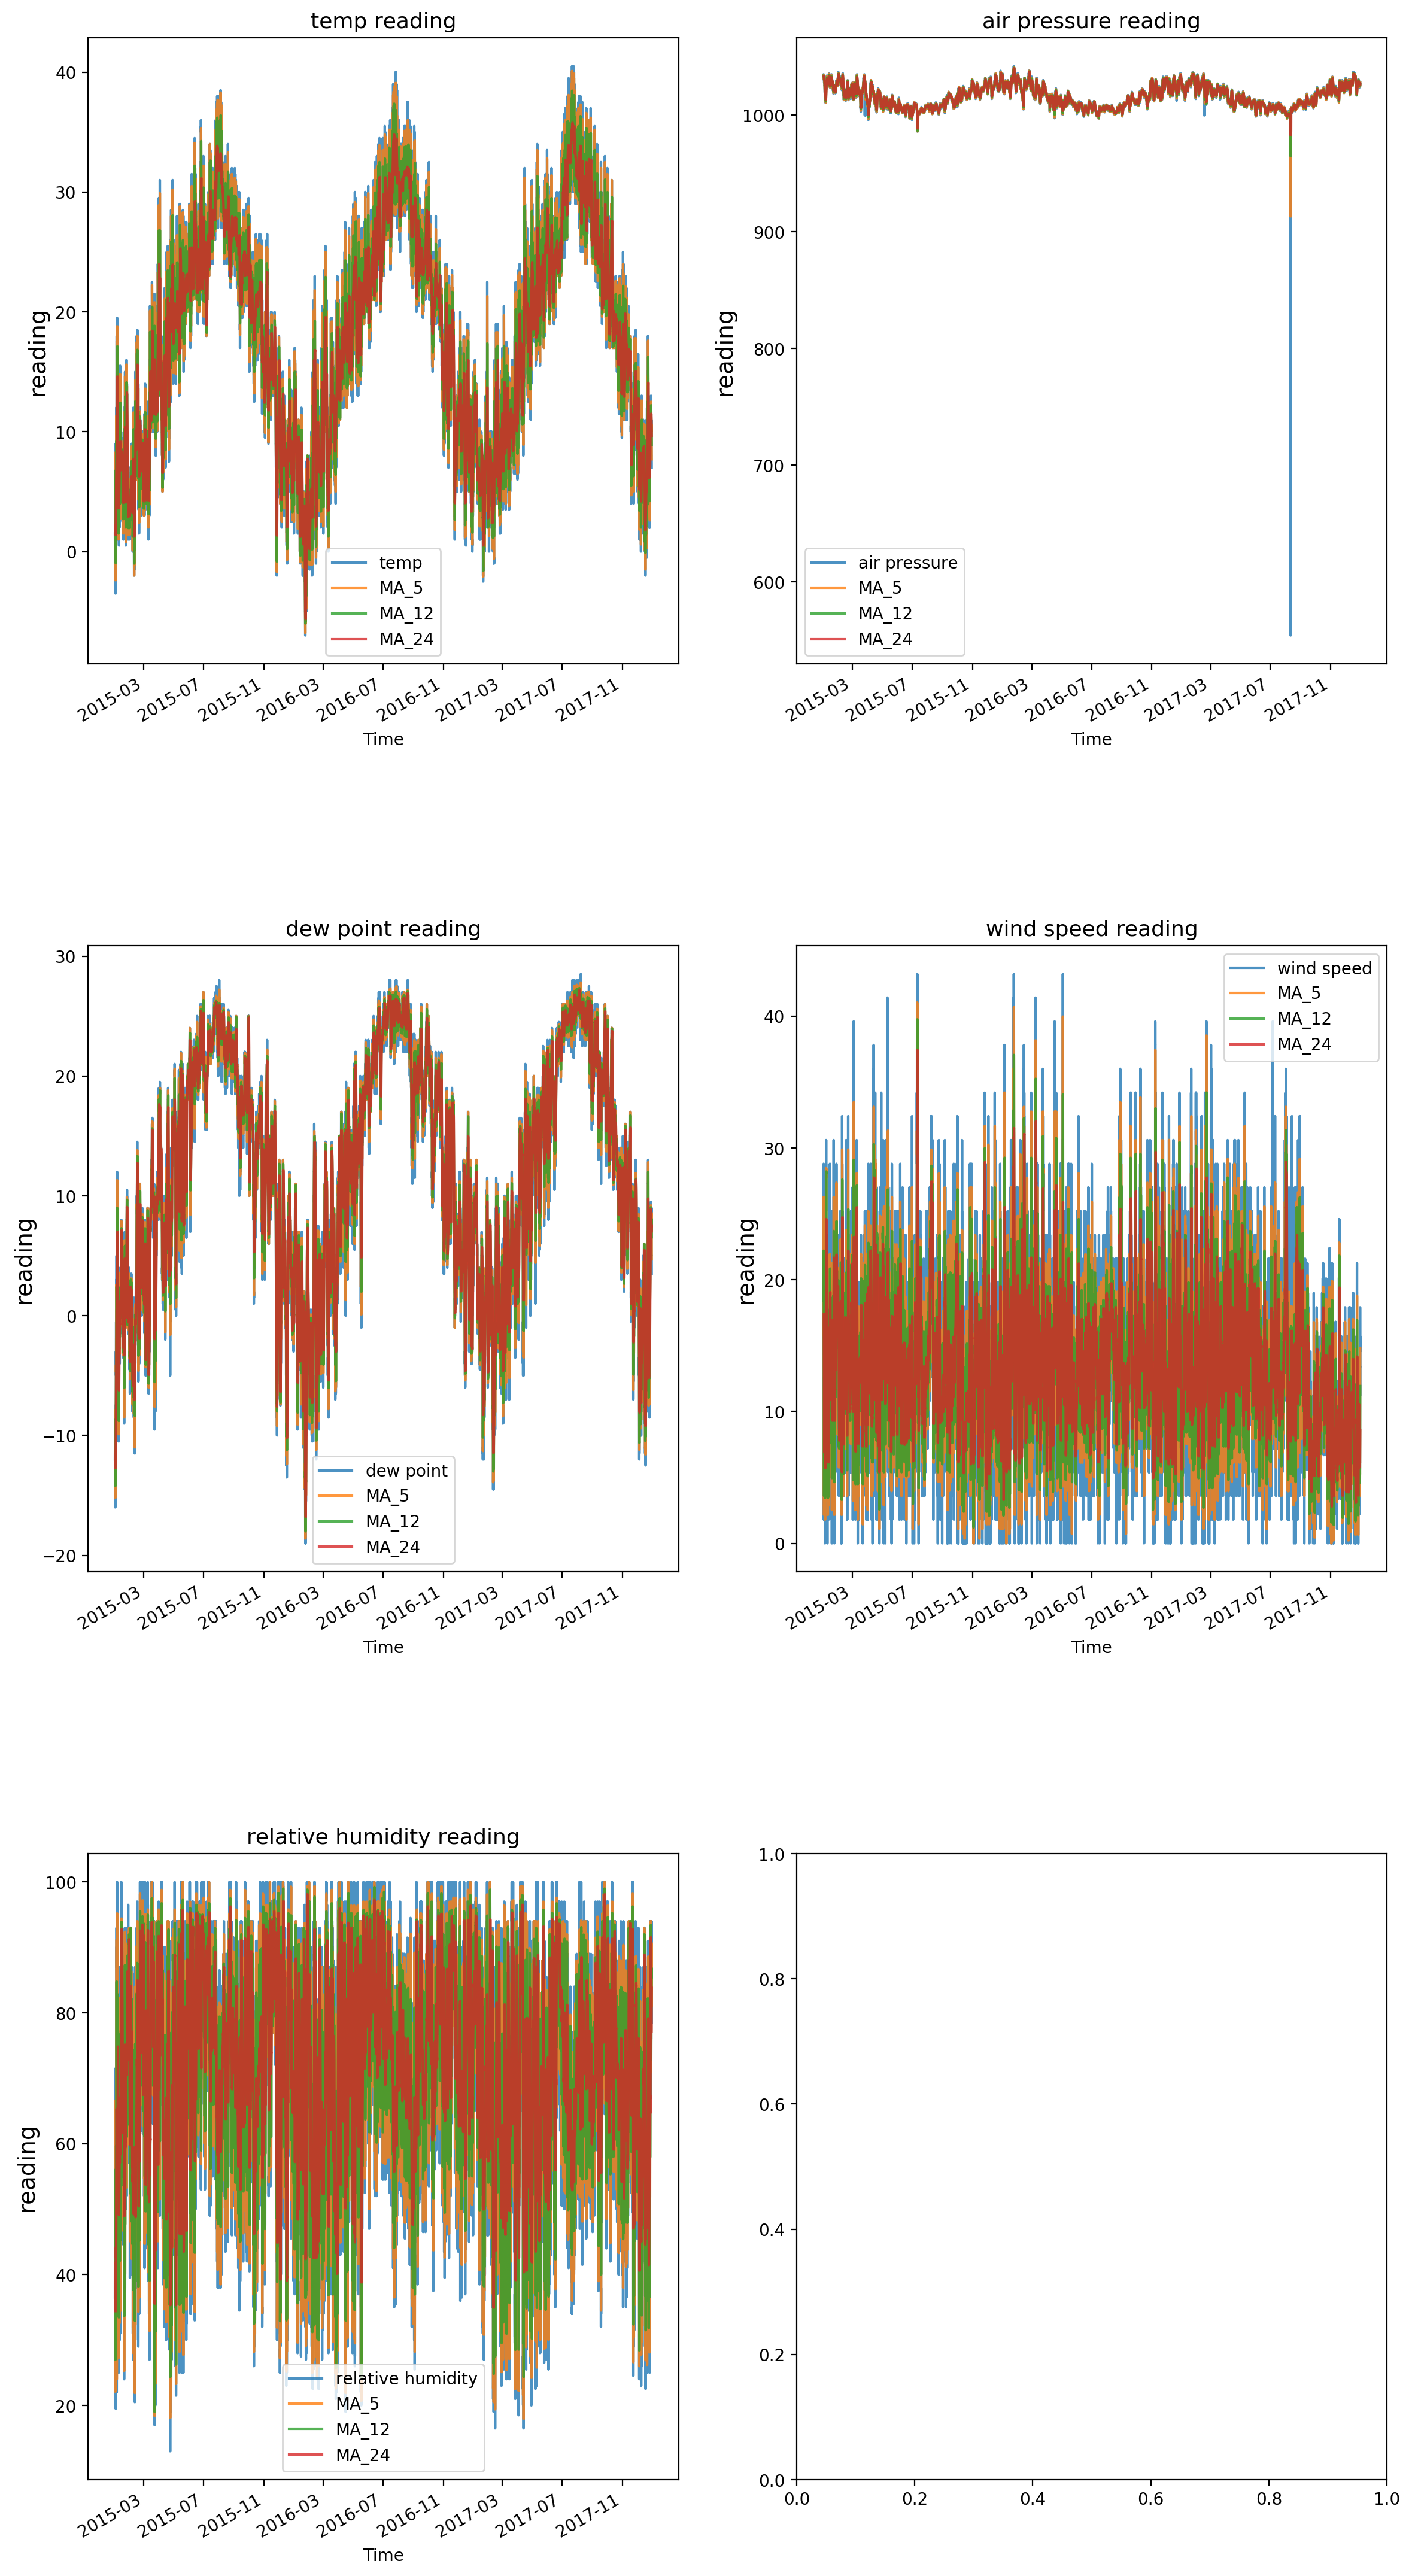

In [77]:
df_clean = pd.read_pickle('./data/df_clean_with_holiday.pkl')
fig, axes = plt.subplots(3,2,figsize=(14, 30), dpi=100)
cols = ['temp', 'dew point','relative humidity', 'air pressure', 'wind speed']
for i in range(5):
    col = cols[i]
    df_clean[['Time', col]].drop_duplicates().set_index('Time').plot(ax=axes[i%3][i//3], label='Actual', alpha=0.8).set_ylabel('reading', fontsize=14)
    df_clean[['Time', col]].drop_duplicates().set_index('Time')[col].rolling(window=5).mean().plot(ax=axes[i%3][i//3], label='MA_5', alpha=0.8).set_ylabel('reading', fontsize=14)
    df_clean[['Time', col]].drop_duplicates().set_index('Time')[col].rolling(window=12).mean().plot(ax=axes[i%3][i//3], label='MA_12', alpha=0.8).set_ylabel('reading', fontsize=14)
    df_clean[['Time', col]].drop_duplicates().set_index('Time')[col].rolling(window=24).mean().plot(ax=axes[i%3][i//3], label='MA_24', alpha=0.8).set_ylabel('reading', fontsize=14)
    axes[i%3][i//3].legend()
    axes[i%3][i//3].set_title('{} reading'.format(col), fontsize=13)
    plt.subplots_adjust(hspace=0.45)

In [9]:
# clean the air presssure data and generate the moving average for each measurement
df_clean = pd.read_pickle('./data/df_clean_with_holiday.pkl')
df_clean.loc[df_clean['air pressure'] < 950, 'air pressure'] = 1003.0
cols = ['Time', 'temp', 'dew point','relative humidity', 'air pressure', 'wind speed']

weather = df_clean[cols].drop_duplicates()
df_clean.drop(columns= cols[1:], inplace= True)
for col in cols[1:]:
    weather[f'{col}_3MA'] =  weather[col].rolling(window=3).mean().fillna(method ='backfill')

    weather[f'{col}_12MA'] = weather[col].rolling(window=12).mean().fillna(method ='backfill')

    weather[f'{col}_24MA'] = weather[col].rolling(window=24).mean().fillna(method ='backfill')


df_clean = df_clean.merge(weather, how= 'left', on='Time')

df_clean =reduce_mem_usage(df_clean)

print(f'before remove bais, length is {len(df_clean)}')
#df_clean = df_clean[df_clean['continous_value_flag'] == 0]
print(f'after remove bais, length is {len(df_clean)}')
# modify the record by dividing the area
df_clean['meter/area'] = df_clean['Record']/df_clean['Area']
# df_clean['meter/area'] = np.log1p(df_clean['Record']/df_clean['Area'])

del weather
gc.collect()

Mem. usage decreased to 96.74 Mb (51.7% reduction)
before remove bais, length is 1045768
after remove bais, length is 1045768


11

In [10]:
df_clean['Encoded-Type'] = df_clean['Type'].astype('category').cat.codes.values
df_clean['Encoded-Stair1'] = df_clean['Stair1'].astype('category')                                                                      
df_clean['Encoded-Stair2'] = df_clean['Stair2'].astype('category')


df_clean['US_Holiday'] = df_clean['US_Holiday'].astype('category').cat.codes.values
df_clean['Chinese_Holiday'] = df_clean['Chinese_Holiday'].astype('category').cat.codes.values

df1 = (df_clean.groupby(['Encoded-Type','month'])
        .agg({'meter/area':'mean'})
        .reset_index()
        .rename(columns={'meter/area':'Avg_Type_month'}))

df2 = (df_clean.groupby(['Encoded-Type','weekday'])
        .agg({'meter/area':'mean'})
        .reset_index()
        .rename(columns={'meter/area':'Avg_Type_weekday'}))

df3 = (df_clean.groupby(['Encoded-Type','hour'])
        .agg({'meter/area':'mean'})
        .reset_index()
        .rename(columns={'meter/area':'Avg_Type_hour'}))

df4 = (df_clean.groupby(['Encoded-Type','Encoded-HVACType','month'])
        .agg({'meter/area':'mean'})
        .reset_index()
        .rename(columns={'meter/area':'Avg_meter_HVACType_month'}))

df5 = (df_clean.groupby(['Encoded-Type','Encoded-HVACType','weekday'])
        .agg({'meter/area':'mean'})
        .reset_index()
        .rename(columns={'meter/area':'Avg_meter_HVACType_weekday'}))

df6 = (df_clean.groupby(['Encoded-Type','Encoded-HVACType','hour'])
        .agg({'meter/area':'mean'})
        .reset_index()
        .rename(columns={'meter/area':'Avg_meter_HVACType_hour'}))

df7 = (df_clean.groupby(['Encoded-Type','Encoded-Stair1','month'])
        .agg({'meter/area':'mean'})
        .reset_index()
        .rename(columns={'meter/area':'Avg_meter_stair_month'}))

df8 = (df_clean.groupby(['Encoded-Type','Encoded-Stair1','weekday'])
        .agg({'meter/area':'mean'})
        .reset_index()
        .rename(columns={'meter/area':'Avg_meter_stair_weekday'}))

df9 = (df_clean.groupby(['Encoded-Type','Encoded-Stair1','hour'])
        .agg({'meter/area':'mean'})
        .reset_index()
        .rename(columns={'meter/area':'Avg_meter_stair_hour'}))
    
df10 = (df_clean.groupby(['Encoded-Type','month','Chinese_Holiday'])
        .agg({'meter/area':'mean'})
        .reset_index()
        .rename(columns={'meter/area':'Avg_meter_month_Chinese_Holiday'}))

df11 = (df_clean.groupby(['Encoded-Type','month','US_Holiday'])
        .agg({'meter/area':'mean'})
        .reset_index()
        .rename(columns={'meter/area':'Avg_meter_month_US_Holiday'}))

df12 = (df_clean.groupby(['Encoded-Type','Encoded-Stair2','month'])
        .agg({'meter/area':'mean'})
        .reset_index()
        .rename(columns={'meter/area':'Avg_meter_stair2_month'}))

df13 = (df_clean.groupby(['Encoded-Type','Encoded-Stair2','weekday'])
        .agg({'meter/area':'mean'})
        .reset_index()
        .rename(columns={'meter/area':'Avg_meter_stair2_weekday'}))

df14 = (df_clean.groupby(['Encoded-Type','Encoded-Stair2','hour'])
        .agg({'meter/area':'mean'})
        .reset_index()
        .rename(columns={'meter/area':'Avg_meter_stair2_hour'}))

df = df_clean.merge(df1, how='left', on=['Encoded-Type','month'])
df = df.merge(df2, how='left', on=['Encoded-Type','weekday'])
df = df.merge(df3, how='left', on=['Encoded-Type','hour'])
df = df.merge(df4, how='left', on=['Encoded-Type','Encoded-HVACType','month'])
df = df.merge(df5, how='left', on=['Encoded-Type','Encoded-HVACType','weekday'])
df = df.merge(df6, how='left', on=['Encoded-Type','Encoded-HVACType','hour'])
df = df.merge(df7, how='left', on=['Encoded-Type','Encoded-Stair1','month'])
df = df.merge(df8, how='left', on=['Encoded-Type','Encoded-Stair1','weekday'])
df = df.merge(df9, how='left', on=['Encoded-Type','Encoded-Stair1','hour'])
df = df.merge(df10, how='left', on=['Encoded-Type','month','Chinese_Holiday'])
df = df.merge(df11, how='left', on=['Encoded-Type','month','US_Holiday'])
df = df.merge(df12, how='left', on=['Encoded-Type','Encoded-Stair2','month'])
df = df.merge(df13, how='left', on=['Encoded-Type','Encoded-Stair2','weekday'])
df = df.merge(df14, how='left', on=['Encoded-Type','Encoded-Stair2','hour'])

del df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14
gc.collect()

0

In [ ]:
df = reduce_mem_usage(df)
df.to_pickle('./data/df_all_noremoveC_addStair2_target_addMA.pkl')
del df, df_clean
gc.collect()

In [36]:

# df_clean['Encoded-Type'] = df_clean['Type'].astype('category').cat.codes.values
# df_clean['Encoded-Stair1'] = df_clean['Stair1'].astype('category')                                                                      
# df_clean['Encoded-Stair2'] = df_clean['Stair2'].astype('category')


# df_clean['US_Holiday'] = df_clean['US_Holiday'].astype('category').cat.codes.values
# df_clean['Chinese_Holiday'] = df_clean['Chinese_Holiday'].astype('category').cat.codes.values

# df1 = (df_clean.groupby(['Encoded-Type','month'])
#         .agg({'Record':'mean'})
#         .reset_index()
#         .rename(columns={'Record':'Avg_Type_month'}))

# df2 = (df_clean.groupby(['Encoded-Type','weekday'])
#         .agg({'Record':'mean'})
#         .reset_index()
#         .rename(columns={'Record':'Avg_Type_weekday'}))

# df3 = (df_clean.groupby(['Encoded-Type','hour'])
#         .agg({'Record':'mean'})
#         .reset_index()
#         .rename(columns={'Record':'Avg_Type_hour'}))

# df4 = (df_clean.groupby(['Encoded-Type','Encoded-HVACType','month'])
#         .agg({'Record':'mean'})
#         .reset_index()
#         .rename(columns={'Record':'Avg_meter_HVACType_month'}))

# df5 = (df_clean.groupby(['Encoded-Type','Encoded-HVACType','weekday'])
#         .agg({'Record':'mean'})
#         .reset_index()
#         .rename(columns={'Record':'Avg_meter_HVACType_weekday'}))

# df6 = (df_clean.groupby(['Encoded-Type','Encoded-HVACType','hour'])
#         .agg({'Record':'mean'})
#         .reset_index()
#         .rename(columns={'Record':'Avg_meter_HVACType_hour'}))

# df7 = (df_clean.groupby(['Encoded-Type','Encoded-Stair1','month'])
#         .agg({'Record':'mean'})
#         .reset_index()
#         .rename(columns={'Record':'Avg_meter_stair_month'}))

# df8 = (df_clean.groupby(['Encoded-Type','Encoded-Stair1','weekday'])
#         .agg({'Record':'mean'})
#         .reset_index()
#         .rename(columns={'Record':'Avg_meter_stair_weekday'}))

# df9 = (df_clean.groupby(['Encoded-Type','Encoded-Stair1','hour'])
#         .agg({'Record':'mean'})
#         .reset_index()
#         .rename(columns={'Record':'Avg_meter_stair_hour'}))
    
# df10 = (df_clean.groupby(['Encoded-Type','month','Chinese_Holiday'])
#         .agg({'Record':'mean'})
#         .reset_index()
#         .rename(columns={'Record':'Avg_meter_month_Chinese_Holiday'}))

# df11 = (df_clean.groupby(['Encoded-Type','month','US_Holiday'])
#         .agg({'Record':'mean'})
#         .reset_index()
#         .rename(columns={'Record':'Avg_meter_month_US_Holiday'}))

# df12 = (df_clean.groupby(['Encoded-Type','Encoded-Stair2','month'])
#         .agg({'Record':'mean'})
#         .reset_index()
#         .rename(columns={'Record':'Avg_meter_stair2_month'}))

# df13 = (df_clean.groupby(['Encoded-Type','Encoded-Stair2','weekday'])
#         .agg({'Record':'mean'})
#         .reset_index()
#         .rename(columns={'Record':'Avg_meter_stair2_weekday'}))

# df14 = (df_clean.groupby(['Encoded-Type','Encoded-Stair2','hour'])
#         .agg({'Record':'mean'})
#         .reset_index()
#         .rename(columns={'Record':'Avg_meter_stair2_hour'}))

# df = df_clean.merge(df1, how='left', on=['Encoded-Type','month'])
# df = df.merge(df2, how='left', on=['Encoded-Type','weekday'])
# df = df.merge(df3, how='left', on=['Encoded-Type','hour'])
# df = df.merge(df4, how='left', on=['Encoded-Type','Encoded-HVACType','month'])
# df = df.merge(df5, how='left', on=['Encoded-Type','Encoded-HVACType','weekday'])
# df = df.merge(df6, how='left', on=['Encoded-Type','Encoded-HVACType','hour'])
# df = df.merge(df7, how='left', on=['Encoded-Type','Encoded-Stair1','month'])
# df = df.merge(df8, how='left', on=['Encoded-Type','Encoded-Stair1','weekday'])
# df = df.merge(df9, how='left', on=['Encoded-Type','Encoded-Stair1','hour'])
# df = df.merge(df10, how='left', on=['Encoded-Type','month','Chinese_Holiday'])
# df = df.merge(df11, how='left', on=['Encoded-Type','month','US_Holiday'])
# df = df.merge(df12, how='left', on=['Encoded-Type','Encoded-Stair2','month'])
# df = df.merge(df13, how='left', on=['Encoded-Type','Encoded-Stair2','weekday'])
# df = df.merge(df14, how='left', on=['Encoded-Type','Encoded-Stair2','hour'])

In [12]:
# store the configs and functions used in the batch testing 
import energyfuctions as ef
from sklearn.linear_model import RidgeCV
config = [
   ('H', 'Stair1', 20),
   ('C', 'HVACType', '集中式全空气系统'),
   ('Y', 'Time', [2017,1,1])
]
config1=[0,1,2]

def combination_k(s, k):
    if k == 0: 
        return ['']
    subletters = []
    for i in range(len(s)):
        for letter in combination_k(s[i+1:], k-1):
            subletters += [str(s[i]) + str(letter)]
    return subletters

def fliter_data(train, coms):
    for con in coms:
        conf =  config[int(con)]
        train = do_filter_data(train, conf)
    return train

def do_filter_data(train, conf):
    if conf[0] == 'H':
        train = train[train[conf[1]] >= conf[2]]
    elif conf[0] == 'C':
        train = train[train[conf[1]] == conf[2]]
    elif conf[0] == 'Y':
        train = train[train[conf[1]] >= pd.Timestamp(conf[2][0], conf[2][1], conf[2][2])]
    return train

def collect_features(train):
    features =[]
    for col in train.columns:
        if col == 'meter/area' or col == 'target' or col == 'Record' or col == 'Time' or col == 'BuildingID':
            pass
        else:
            features.append(col)
    return features

In [14]:
import energyfuctions as ef

# load the raw data and create the train the test data sets
train = pd.read_pickle('./data/df_all_noremoveC_addStair2_target_addMA.pkl')
train = reduce_mem_usage(train)

building_number =  5 
# train['meter/area'] = train['Record']/train['Area']
train['target'] = np.log1p(train['Record']/train['Area'])
test = train[train['BuildingID'] == building_number]
test = test[test['Time'] >= '2017-01-01']
# train = train[train['BuildingID'] != building_number]
drop_cols = ['Type', 'HVACType', 'By_day_record', 'continous_value_flag', 'Stair1', 'Stair2']
# train.drop(drop_cols, 1, inplace=True)
test.drop(drop_cols, 1, inplace=True)

for i in range (1,4):
    combs = combination_k(config1, i)
    for com in combs:
        print(f'processing the train data with combine of {com}')
        train_set  = fliter_data(train, com)

        train_set.drop(drop_cols, 1, inplace=True)
        features = collect_features(train_set)
        print(f'training set size is {len(train_set)},  \n  test data set size is {len(test)}' )
        # output the best model path 
        test_preds = ef.do_RCV_train(train_set, test, features)
         # output the validation mse result under best model
        # val_result = valida_model(Best_paths, validat_set)
        # record.append({com: [Best_paths, val_result]})

# after this we have train, test, features

Mem. usage decreased to 129.65 Mb (18.7% reduction)
processing the train data with combine of 0
training set size is 682682,  
  test data set size is 17474
Meter 0, training rmse=0.58181, , test rmse=0.80151 
Meter 1, training rmse=1.45988, , test rmse=0.57371 
Overall training set rmse=0.86124
Overall test set for target building rmse=0.66233
processing the train data with combine of 1
training set size is 210056,  
  test data set size is 17474
Meter 0, training rmse=0.39608, , test rmse=0.27104 
Meter 1, training rmse=0.93992, , test rmse=0.56685 
Overall training set rmse=0.63771
Overall test set for target building rmse=0.51750
processing the train data with combine of 2
training set size is 344968,  
  test data set size is 17474
Meter 0, training rmse=0.83260, , test rmse=0.24905 
Meter 1, training rmse=1.39445, , test rmse=0.56577 
Overall training set rmse=1.03452
Overall test set for target building rmse=0.51338
processing the train data with combine of 01
training set size 

Mem. usage decreased to 129.65 Mb (18.7% reduction)
Meter 0, training rmse=0.79139, , test rmse=0.30762 
Meter 1, training rmse=1.35421, , test rmse=0.57384 
Overall training set rmse=0.98965
Overall test set for target building rmse=0.52921


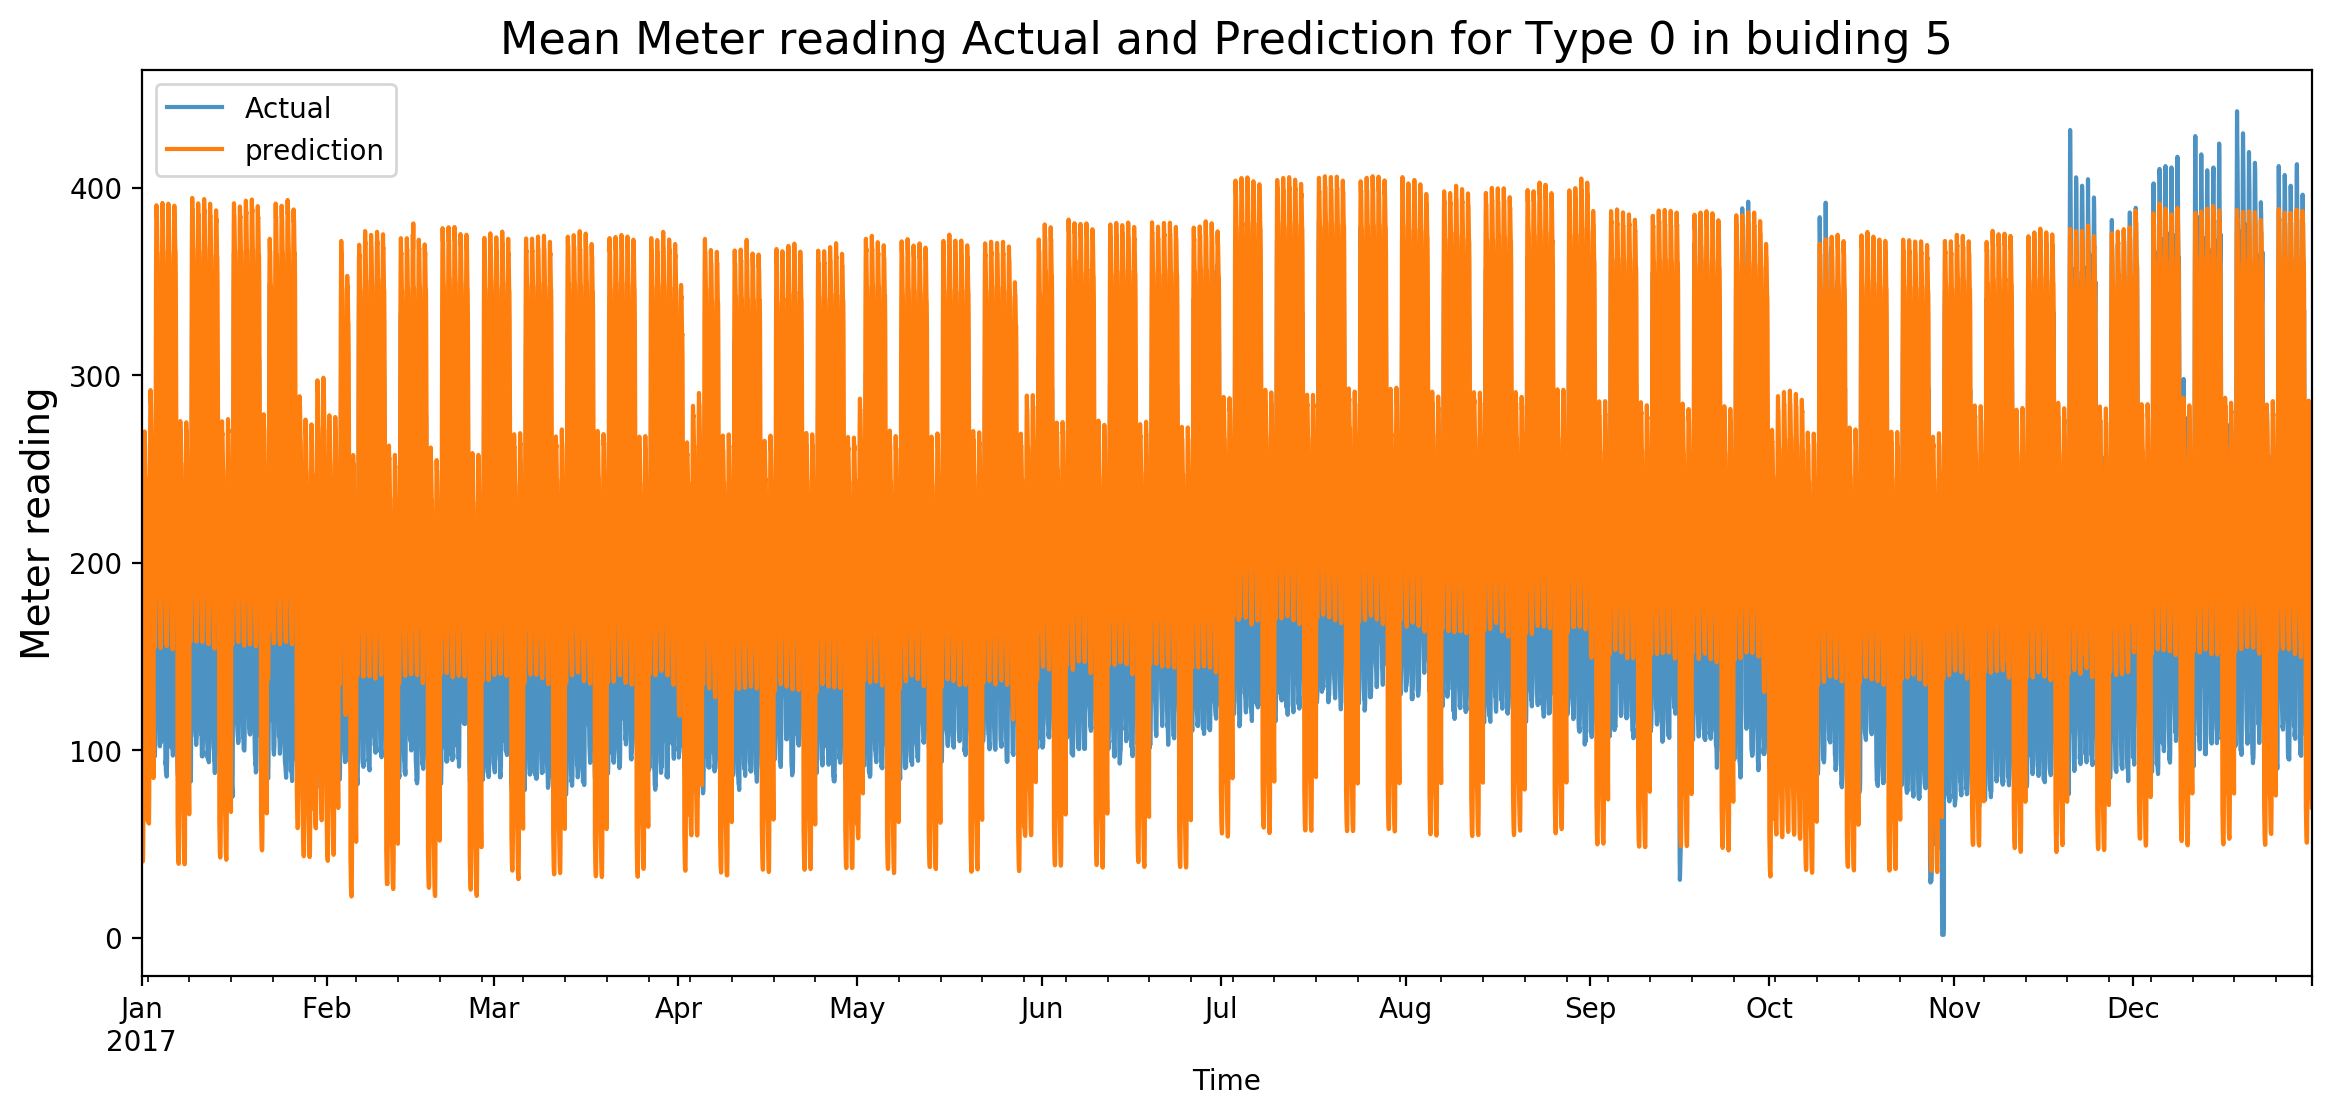

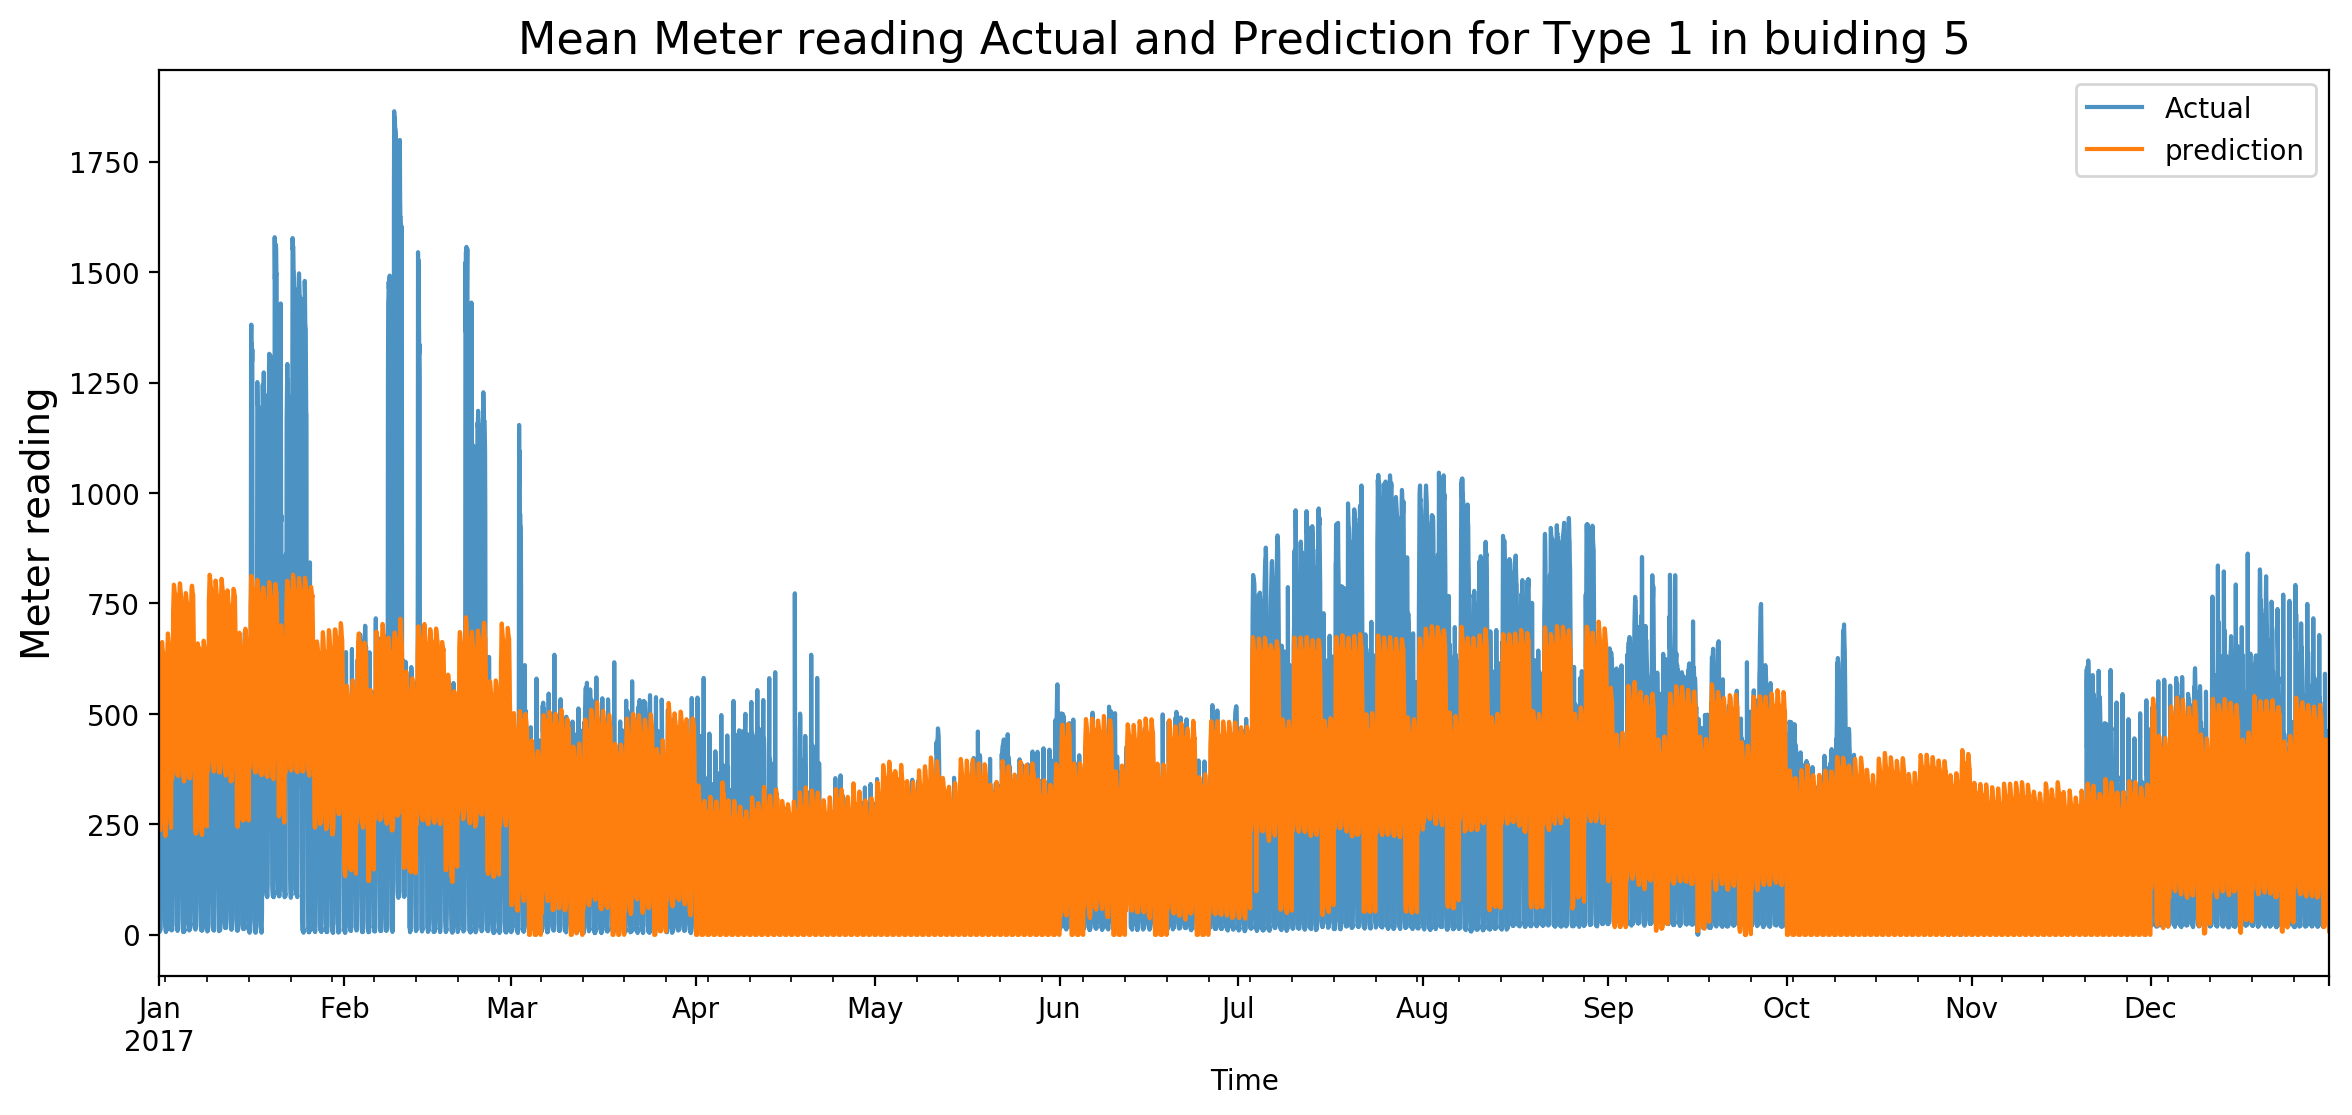

11852

In [15]:
train = pd.read_pickle('./data/df_all_noremoveC_addStair2_target_addMA.pkl')
train = reduce_mem_usage(train)

building_number =  5 
# train['meter/area'] = train['Record']/train['Area']
train['target'] = np.log1p(train['Record']/train['Area'])
test = train[train['BuildingID'] == building_number]
test = test[test['Time'] >= '2017-01-01']
# train = train[train['BuildingID'] != building_number]
drop_cols = ['Type', 'HVACType', 'By_day_record', 'continous_value_flag', 'Stair1', 'Stair2']
train.drop(drop_cols, 1, inplace=True)
test.drop(drop_cols, 1, inplace=True)

features =[]
for col in train.columns:
    if col == 'meter/area' or col == 'target' or col == 'Record' or col == 'Time' or col == 'BuildingID':
        pass
    else:
        features.append(col)
test_preds = ef.do_RCV_train(train, test, features)

ef.draw_prediction_plot(test_preds, test, building_number)

del train, test_preds, test
gc.collect()